In [1]:
%ls

EDA.ipynb  model.ipynb


In [2]:
%cd ../
%ls

/home/majnu/Desktop/final_year_project
input/  notebook/  README.md  saved_model/  utils/


In [3]:
import tensorflow as tf
import os
import glob
import keras
import utils.utils
from utils import SlidingFrameGenerator
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D, Flatten
from keras.layers import TimeDistributed, GRU, Dense, Dropout
print(tf.__version__)

2.5.0


In [4]:
# some global params
data_path='input/data/*'
data_pattern='input/data/{classname}/*.mp4'
test_split_ratio=.20
validation_split_ratio=.20
SIZE = (112, 112)
CHANNELS = 3
NBFRAME = 5
BS = 4

In [6]:
for i in glob.glob(data_path):
    print(i)

input/data/harrasment
input/data/normal


In [5]:
classes = [i.split(os.path.sep)[-1] for i in glob.glob(data_path)]
classes.sort()
print(classes)

['harrasment', 'normal']


In [6]:
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)

In [7]:
# Create video frame generator
train_data = SlidingFrameGenerator(
    classes=classes, 
    glob_pattern=data_pattern,
    nb_frames=NBFRAME,
    split_val=validation_split_ratio, 
    split_test=test_split_ratio,
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=data_aug,
    use_frame_cache=True)

class harrasment, validation count: 35, test count: 28, train count: 116
class normal, validation count: 20, test count: 16, train count: 68
Total data: 2 classes for 184 files for train
Checking files to find possible sequences, please wait...
For 184 files, I found 1104 possible sequence samples


In [8]:
validation_data = train_data.get_validation_generator()
test_data=train_data.get_test_generator()

Total data: 2 classes for 55 files for validation
Checking files to find possible sequences, please wait...
For 55 files, I found 330 possible sequence samples
Total data: 2 classes for 44 files for test
Checking files to find possible sequences, please wait...
For 44 files, I found 264 possible sequence samples


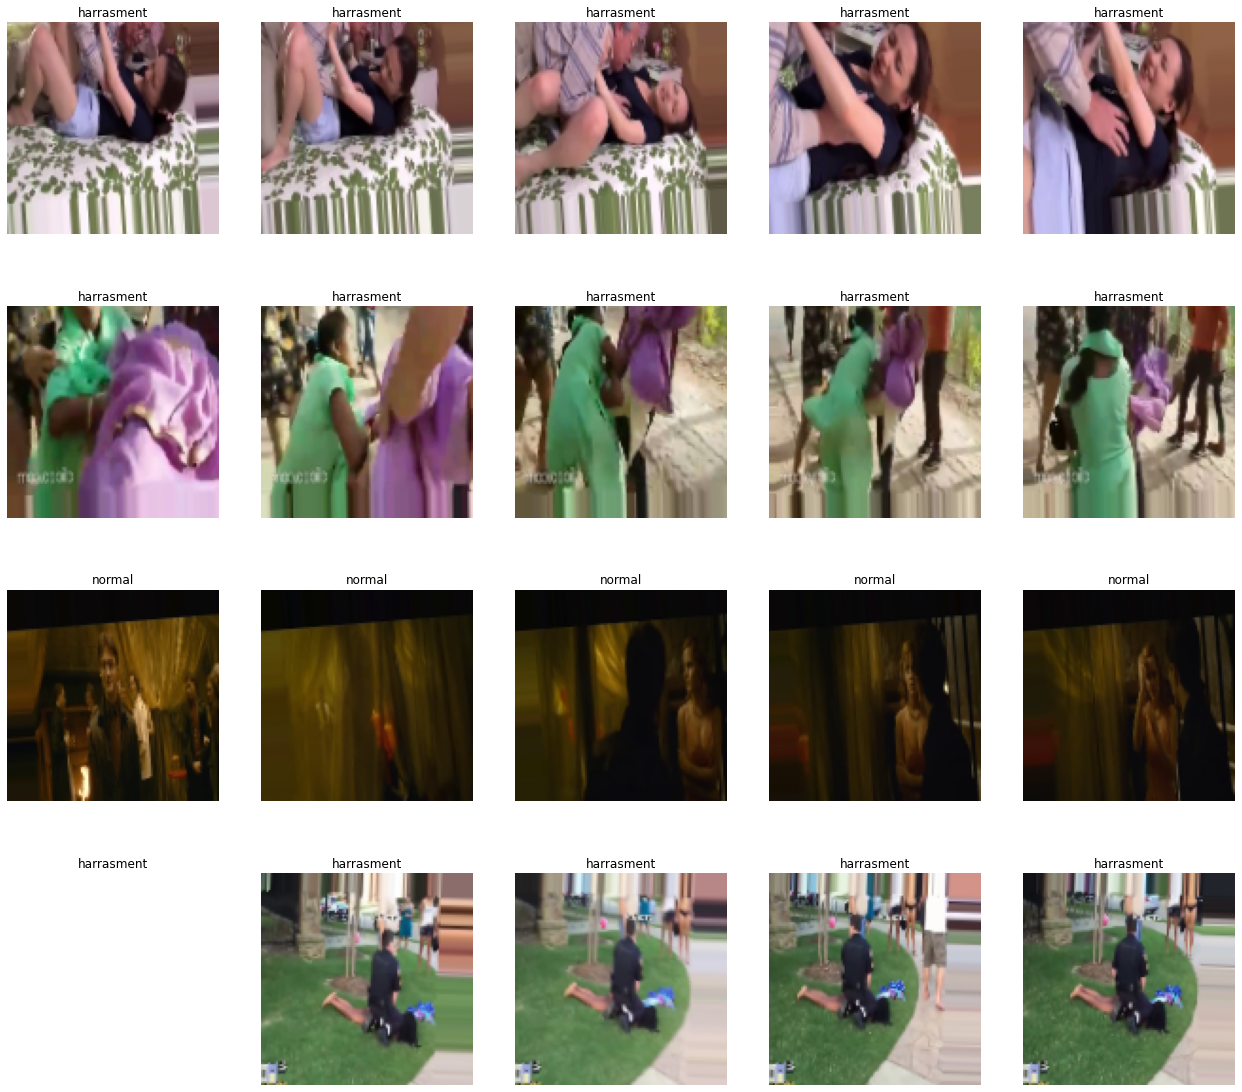

In [23]:
utils.utils.show_sample(train_data)

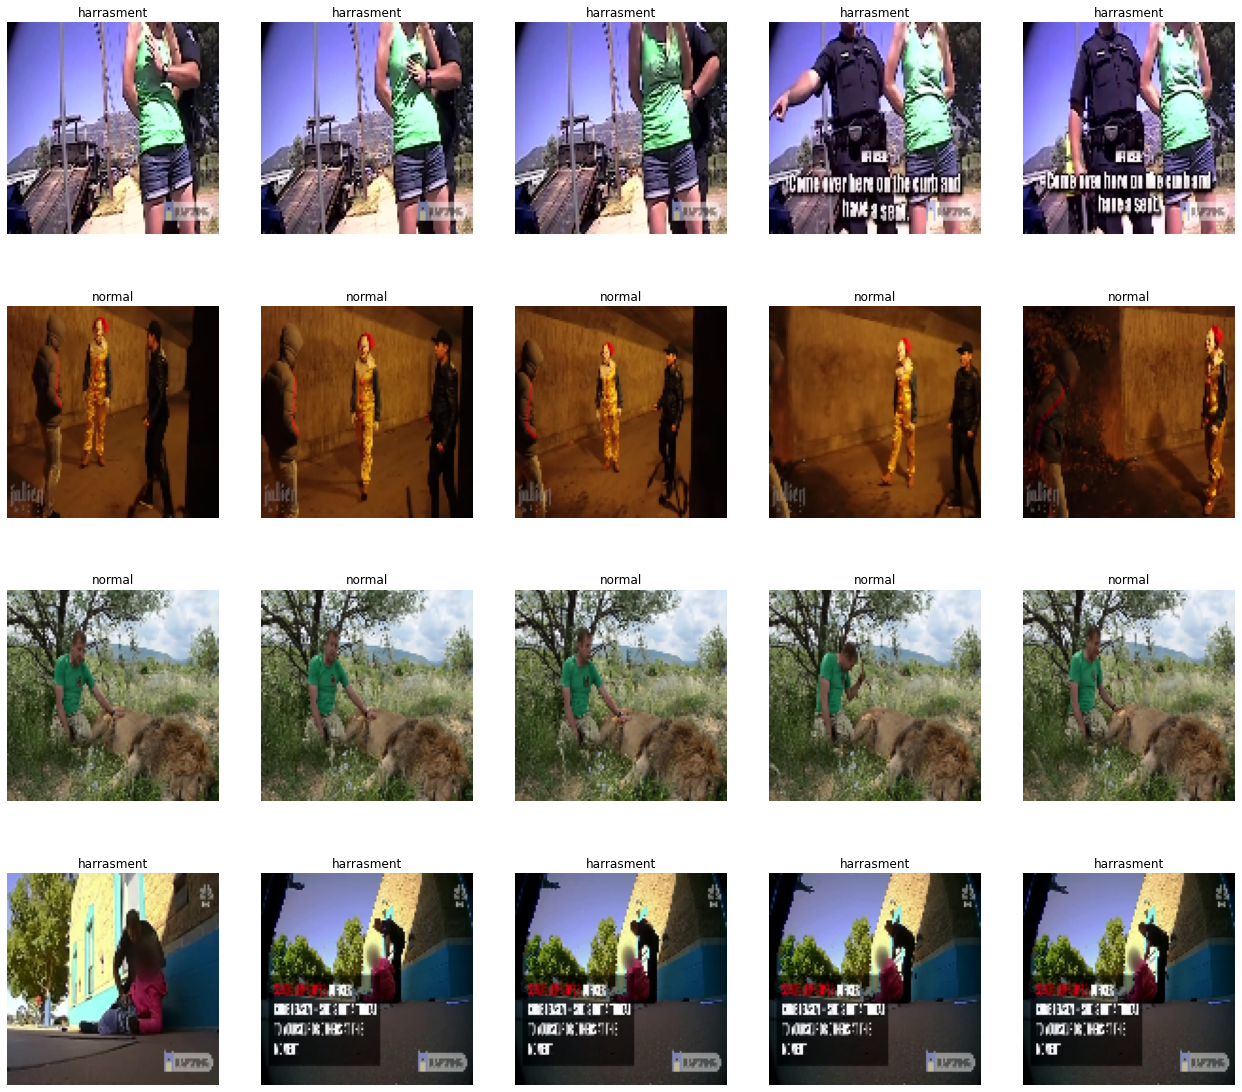

In [20]:

utils.utils.show_sample(validation_data)

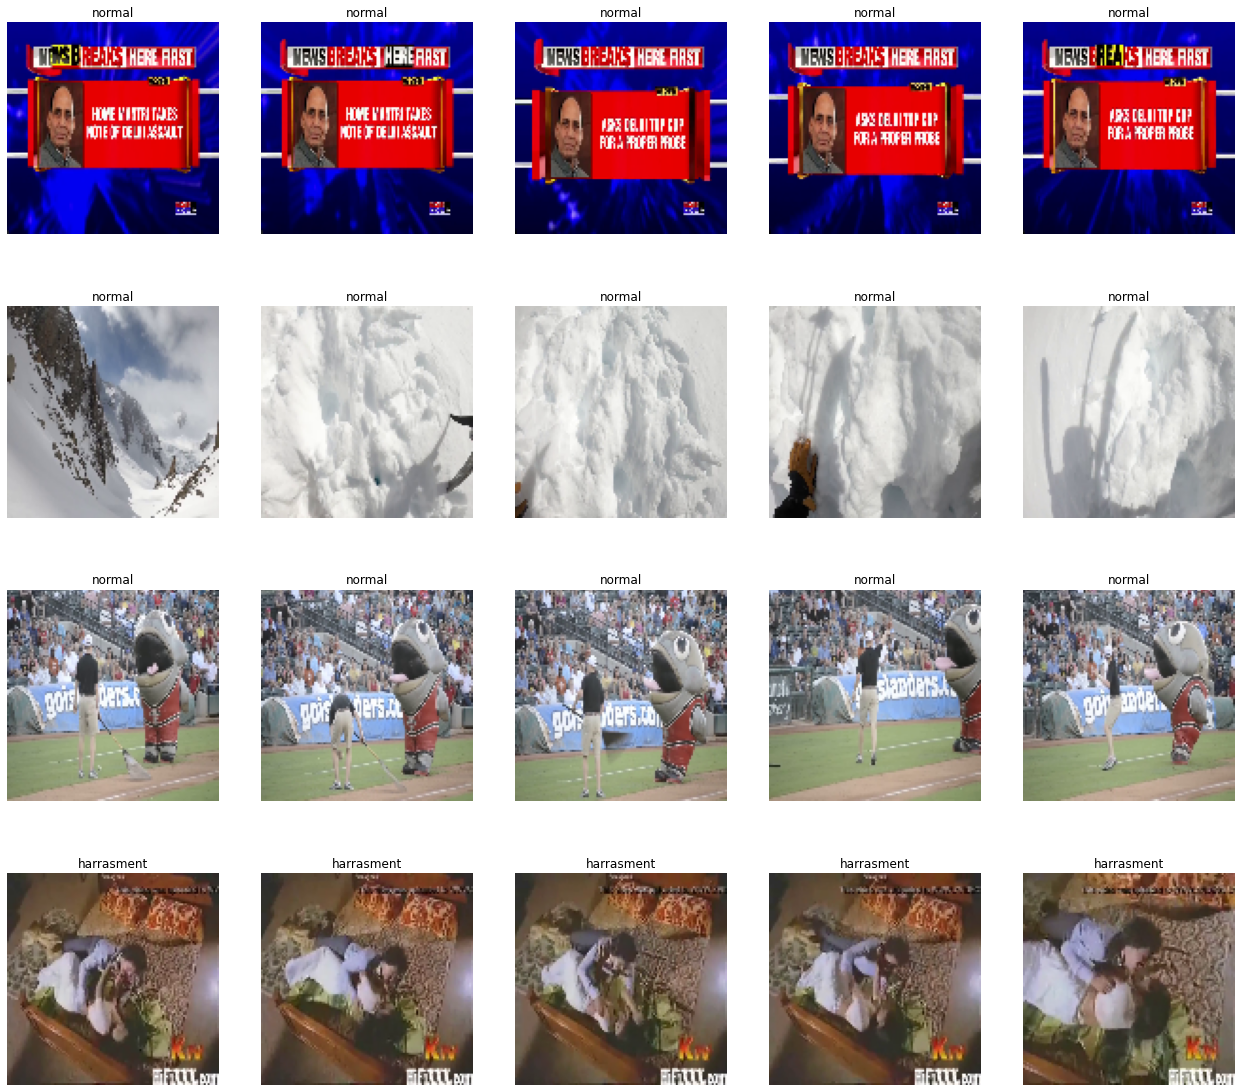

In [24]:
utils.utils.show_sample(test_data)

In [11]:
def build_convnet(shape=(SIZE[0], SIZE[1], CHANNELS)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(Flatten()) #GlobalMaxPool2D()
    return model

In [12]:
def action_model(shape=(BS, SIZE[0], SIZE[1], CHANNELS), nbout=len(classes)):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))
    # here, you can also use GRU or LSTM
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='softmax'))
    return model

In [13]:
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,) # (5, 112, 112, 3)
model = action_model(INSHAPE, len(classes))
# optimizer = tf.keras.optimizers.Adam(0.0001)
model.compile(
    'adam',
    'categorical_crossentropy',
    metrics=['acc', 'AUC']
)

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 5, 100352)         4689216   
_________________________________________________________________
gru (GRU)                    (None, 64)                19280256  
_________________________________________________________________
dense (Dense)                (None, 1024)              66560     
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [43]:
EPOCHS=50
# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1, save_best_only=True, save_weights_only=True),
]
history=model.fit(
    train_data,
    validation_data=validation_data,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)


In [ ]:
model.load_weights('chkp/weights.32-0.34.hdf5')
model.save('saved_model/firstModel.tf')

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
model = tf.keras.models.load_model('saved_model/firstModel.tf')

In [10]:
test_generator = test_data
row_width=22
row_height=5
number_of_batch = 10 #len(test_generator)


rows = number_of_batch * BS
index = 1
plt.figure(figsize=(row_width, row_height*rows))
for i in tqdm_notebook(range(number_of_batch)):
  sample = test_generator[i]
  sequences = sample[0]
  labels = sample[1]
  prediction = model.predict(sequences)

  
  for batchid, sequence in enumerate(sequences):
    g_classid = np.argmax(labels[batchid])
    g_classname = "Ground :"+test_generator.classes[g_classid]

    p_classid = np.argmax(prediction[batchid])
    p_classname = "Prediction :"+test_generator.classes[p_classid]

    title = g_classname + "\n" + p_classname

    cols = len(sequence)
    for image in sequence:
        plt.subplot(rows, cols, index)
        plt.title(title)
        plt.imshow(image)
        plt.axis('off')
        index += 1
plt.show()

<ipython-input-10-95fd4ec28173>:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(number_of_batch)):


  0%|          | 0/10 [00:00<?, ?it/s]